In [47]:
import datetime
import json
import os
import pickle
import time

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (
    Activation,
    AveragePooling2D,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Rescaling,
)
from keras.models import Sequential
from keras.preprocessing import image
from PIL import Image, ImageFont
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Disable tenforflow information messages about GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [48]:
pwd = os.getcwd()
dir_aug_data = os.path.join(pwd, "data/casting_512x512")

In [49]:
# Load training set
original_train_data = tf.keras.utils.image_dataset_from_directory(
    directory=dir_aug_data,
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.25,
    subset="training",
    seed=123,
)

# Load test set
original_test_data = tf.keras.utils.image_dataset_from_directory(
    directory=dir_aug_data,
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.25,
    subset="validation",
    seed=123,
)

Found 1300 files belonging to 2 classes.
Using 975 files for training.
Found 1300 files belonging to 2 classes.
Using 325 files for validation.


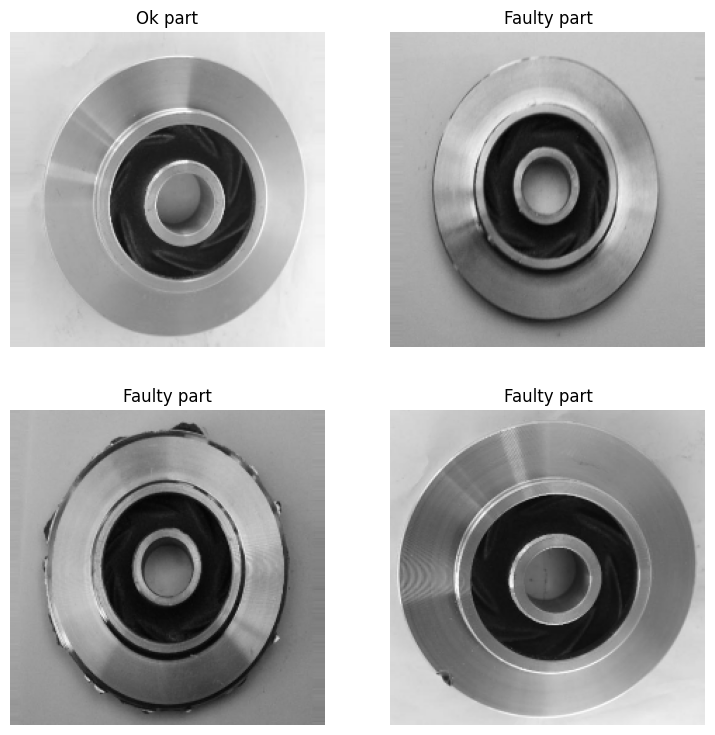

In [50]:
image, label = next(iter(original_train_data))

plt.figure(figsize=(9, 9))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(image[i].numpy().astype(np.uint8))
    plt.title(
        "Faulty part"
        if label[i].numpy().astype(np.uint8) == 0
        else "Ok part"
    )
    plt.axis("off")

In [51]:
# Create a keras Sequential layer to perform several trasnformations and generate an
# augmented dataset
data_augmentation = Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation((0, 0.9), fill_mode="constant"),
        keras.layers.RandomZoom(0.05, fill_mode="constant"),
        keras.layers.RandomContrast(0.25),
#         keras.layers.RandomBrightness(0.25),
    ]
)

In [52]:
def save_augmented_images(data, data_type, path_images):
    """
    Augment an image dataset by performing transformations on the original images.
    Each image is transformed a total of 6 times.
    Note that the training and testing datasets are saved separately to avoid data leakage
    
    Args:
        - data: image dataset as a BatchDataset
        - data_type: string containing type of dataset, i.e. train or test
        - path_images: directory where the user wishes to save the data
    """
    count_ok = 1
    count_def = 1
    for batch in data:
        (images, labels) = batch

        for i in range(images.shape[0]):
            if labels[i].numpy() == 0:
                for j in range(6):
                    augmented_image = data_augmentation(images[i], training=True)
                    img = Image.fromarray(augmented_image.numpy().astype(np.uint8))
                    img.save(
                        os.path.join(
                            path_images
                            + "/"
                            + data_type
                            + "/def_front/"
                            + str(count_def)
                            + ".jpeg"
                        )
                    )
                    count_def += 1

            else:
                for j in range(6):
                    augmented_image = data_augmentation(images[i], training=True)
                    img = Image.fromarray(augmented_image.numpy().astype(np.uint8))
                    img.save(
                        os.path.join(
                            path_images
                            + "/"
                            + data_type
                            + "/ok_front/"
                            + str(count_ok)
                            + ".jpeg"
                        )
                    )
                    count_ok += 1

In [60]:
# Define the main path
path_images = os.getcwd() + "/data/casting_data_augm"

# Create the files if they don't already exist
if os.path.exists(path_images):
    print("Data folder already exists")
else:
    os.makedirs(path_images)
    os.makedirs(path_images + "/train/def_front")
    os.makedirs(path_images + "/train/ok_front")
    os.makedirs(path_images + "/test/def_front")
    os.makedirs(path_images + "/test/ok_front")

# Perform data augmentation only if doesn't exist already
if len(os.listdir(os.getcwd() + "/data/casting_data_augm/train/def_front")) != 0:
    print("Augmented images have already been generated")
else:
    save_augmented_images(original_train_data, "train", path_images)
    save_augmented_images(original_test_data, "test", path_images)

In [64]:
# set the directories pointing to the data
pwd = os.getcwd()
dir_train_data = pwd + "/data/casting_data_augm/train"
dir_test_data = pwd + "/data/casting_data_augm/test"

# train split from the training directory
train_data = tf.keras.utils.image_dataset_from_directory(
    directory=dir_train_data,
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
)

Found 5850 files belonging to 2 classes.


In [66]:
# test split from the test directory
# the idea is to use the test split for choosing the right model and therefore we need more images than
# the validation set. The test set uses "training" for the subset argument, but it won't be used for training
# purposes. The argument is used by the function to decide which is the bigger split
test_data = tf.keras.utils.image_dataset_from_directory(
    directory=dir_test_data,
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
    validation_split=0.15,
    subset="training",
)

# validation (hold-out) set
# It's a subset of the test set
val_data = tf.keras.utils.image_dataset_from_directory(
    directory=dir_test_data,
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
    validation_split=0.15,
    subset="validation",
)

# train split for the simple classification algorithms
train_data_pca = tf.keras.utils.image_dataset_from_directory(
    directory=dir_train_data,
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
    validation_split=0.15,
    subset="validation",
)

# train split for the simple classification algorithms
test_data_pca = tf.keras.utils.image_dataset_from_directory(
    directory=dir_test_data,
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
    validation_split=0.15,
    subset="validation",
)

Found 1950 files belonging to 2 classes.
Using 1658 files for training.
Found 1950 files belonging to 2 classes.
Using 292 files for validation.
Found 5850 files belonging to 2 classes.
Using 877 files for validation.
Found 1950 files belonging to 2 classes.
Using 292 files for validation.


In [68]:
# Check the size of the images to maker sure it was saved correctly
# Also, check the maximum pixel value to make sure they weren't scaled
# before
image_batch, labels_batch = next(iter(train_data))

print("Image shape is", image_batch[0].numpy().shape)
print("Max pixel values is", np.max(image_batch[0].numpy()))

Image shape is (224, 224, 3)
Max pixel values is 230.0


In [70]:
# Check the size of the batches
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [72]:
# Check the number and name of the classes, which is inferred from the
# folder structure
train_data.class_names

['def_front', 'ok_front']

In [74]:
# Define the scaling layer
scaling_layer = Rescaling(1.0 / 255)

# Scale the datasets
train_data_scaled = train_data.map(lambda x, y: (scaling_layer(x), y))
test_data_scaled = test_data.map(lambda x, y: (scaling_layer(x), y))
train_data_pca_scaled = train_data_pca.map(lambda x, y: (scaling_layer(x), y))
test_data_pca_scaled = test_data_pca.map(lambda x, y: (scaling_layer(x), y))

# Test that the scaling has worked by printing the min and max value from one the images
image_batch, labels_batch = next(iter(train_data_scaled))

image = image_batch[0]
print(np.min(image), np.max(image))

0.0 0.9686275


In [76]:
AUTOTUNE = tf.data.AUTOTUNE

train_data_scaled = train_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)
test_data_scaled = test_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)

In [78]:
def flatten_rgb_images(images_data, data_size):
    """
    Separate an RGB image dataset into three different variables and flatten each new variable

    Args:
        - images_data: image dataset containing RGB images
        - data_size: size of dataset

    Returns:
        - image_flat_r: flattened images of the R channel
        - image_flat_g: flattened images of the G channel
        - image_flat_b: flattened images of the B channel
        - y_data: image labels
    """
    image_flat_r = np.zeros(shape=(data_size, n_components))
    image_flat_g = np.zeros(shape=(data_size, n_components))
    image_flat_b = np.zeros(shape=(data_size, n_components))
    y_data = np.zeros(shape=(data_size, 1))

    count = 0
    for batch in images_data:
        (images, labels) = batch

        for i in range(len(images)):
            image_flat_r[count, :] = images[i].numpy()[:, :, 0].reshape(n_components)
            image_flat_g[count, :] = images[i].numpy()[:, :, 1].reshape(n_components)
            image_flat_b[count, :] = images[i].numpy()[:, :, 2].reshape(n_components)
            y_data[count] = labels[i].numpy()

            count = count + 1

    y_data = y_data.astype(np.uint8)
    return [image_flat_r, image_flat_g, image_flat_b, y_data]


def image_pca(x_data, n_components):
    """
    Define a PCA object using the number of components specified by the user and
    transform the given image dataset.

    Args:
        - x_data: image dataset
        - n_components: number of components for the PCA algorithm

    Returns:
        - fit_pca: PCA model fitted to x_data
        - fit_pca.transform(x_data): transformed image dataset
    """
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)

    print(
        "Variance explained with {0} components:".format(n_components),
        round(sum(fit_pca.explained_variance_ratio_), 5),
    )

    return fit_pca, fit_pca.transform(x_data)

def flatten_transformed_images(images_r, images_g, images_b, data_size):
    """
    Flattened the transformed images and output the information from the three
    RGB channels in a single variable, which will be fed to the classification
    models
    
    Args:
        - images_r: transformed images in the R channel
        - images_g: transformed images in the G channel
        - images_b: transformed images in the B channel
        - data_size: dataset size

    Returns:
        - flat_data: array containing the three flattened RGB channels 
    """
    flat_data = np.zeros(shape=(data_size, images_r.shape[1] * 3))
    image_iter = np.zeros(shape=(images_r.shape[1], 3))

    for i in range(data_size):
        image_iter[:, 0] = images_r[i, :]
        image_iter[:, 1] = images_g[i, :]
        image_iter[:, 2] = images_b[i, :]

        flat_data[i, :] = image_iter.flatten()

    return flat_data

In [80]:
# Define several parameters that will be used by different functions
n_components = 224 * 224
train_data_size = 1298
test_data_size = 292

# Split original image into r,g,b channels and flatten them
[image_flat_r, image_flat_g, image_flat_b, train_labels] = flatten_rgb_images(
    train_data_pca_scaled, train_data_size
)
[image_flat_r_val, image_flat_g_val, image_flat_b_val, test_labels] = flatten_rgb_images(
    test_data_pca_scaled, test_data_size
)

# Perform PCA using 900 components and transform images
pca_r, transformed_images_r = image_pca(image_flat_r, 900)
pca_g, transformed_images_g = image_pca(image_flat_g, 900)
pca_b, transformed_images_b = image_pca(image_flat_b, 900)

Variance explained with 900 components: 1.0
Variance explained with 900 components: 1.0
Variance explained with 900 components: 1.0


In [82]:
print(
    "The overall unexplained variance is %.4f"
    %(
        (1 - np.sum(pca_r.explained_variance_ratio_))
        + (1 - np.sum(pca_g.explained_variance_ratio_))
        + (1 - np.sum(pca_b.explained_variance_ratio_))
    )
)

The overall unexplained variance is 0.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0545175843645893e-12..0.9215686917305033].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.388488266699909e-12..1.0000000000000289].


Text(0.5, 1.0, 'PCA reduced image')

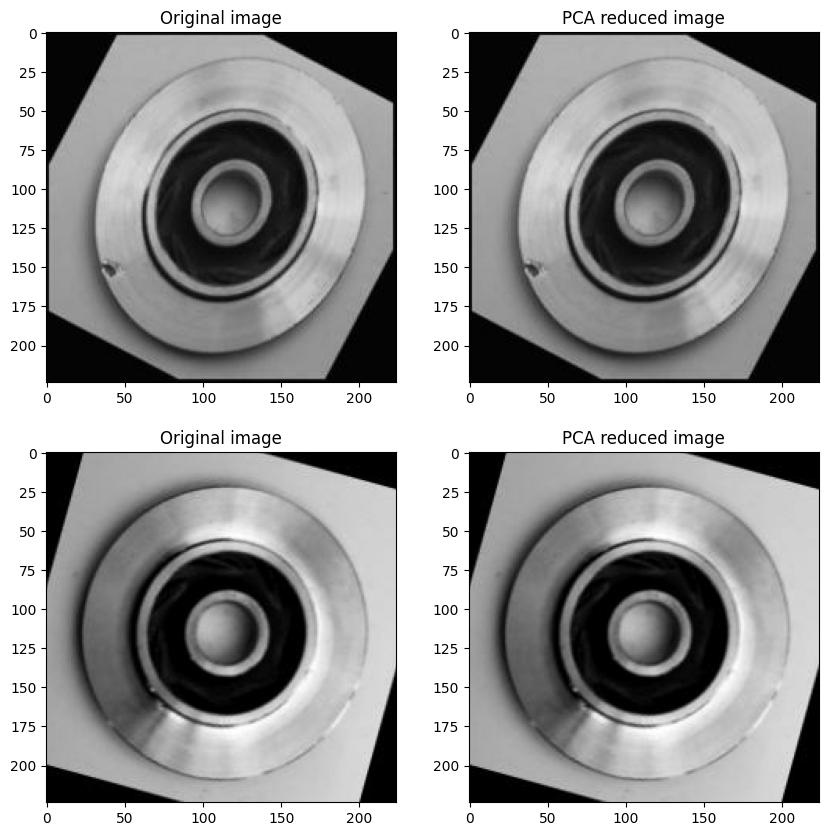

In [84]:
# Inverse transfor the pca imges to retrieve the original image
# Store the r,g and b channels in a single variable to plot them
pca_inv_images = np.zeros(shape=(train_data_size, 224, 224, 3))

pca_inv_images[:, :, :, 0] = pca_r.inverse_transform(transformed_images_r).reshape(
    [train_data_size, 224, 224]
)
pca_inv_images[:, :, :, 1] = pca_g.inverse_transform(transformed_images_g).reshape(
    [train_data_size, 224, 224]
)
pca_inv_images[:, :, :, 2] = pca_b.inverse_transform(transformed_images_b).reshape(
    [train_data_size, 224, 224]
)

# Reconstruct the original images using the flattened arrays
original_images = np.zeros(shape=(train_data_size, 224, 224, 3))

original_images[:, :, :, 0] = image_flat_r.reshape([train_data_size, 224, 224])
original_images[:, :, :, 1] = image_flat_g.reshape([train_data_size, 224, 224])
original_images[:, :, :, 2] = image_flat_b.reshape([train_data_size, 224, 224])

# Compare two images by plotting them
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(original_images[0, :, :, :])
axes[0, 0].set_title("Original image")
axes[0, 1].imshow(pca_inv_images[0, :, :, :])
axes[0, 1].set_title("PCA reduced image")

axes[1, 0].imshow(original_images[1, :, :, :])
axes[1, 0].set_title("Original image")
axes[1, 1].imshow(pca_inv_images[1, :, :, :])
axes[1, 1].set_title("PCA reduced image")

## CNN Models

### Define Functions

In [96]:
class TimeHistory(keras.callbacks.Callback):
    """
    Define a callback to store the runtime per epoch while training a neural network
    """

    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


def loss_accuracy_plot(hist):
    """
    Create 2 plots to understand the performance of the network during training.
    The left plot includes the validation and training loss.
    The right plot presents the training and validation accuracy

    - Input: training history as a list type, such as the history object from training
    a neural network

    - Output: 1x2 plot
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].plot(
        range(1, len(hist.history["loss"]) + 1),
        hist.history["loss"],
        label="training loss",
    )
    axes[0].plot(
        range(1, len(hist.history["loss"]) + 1),
        hist.history["val_loss"],
        label="validation loss",
    )
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss evolution")
    axes[0].legend(loc="best")
    axes[0].grid()

    axes[1].plot(
        range(1, len(hist.history["loss"]) + 1),
        hist.history["accuracy"],
        label="training accuracy",
    )
    axes[1].plot(
        range(1, len(hist.history["loss"]) + 1),
        hist.history["val_accuracy"],
        label="validation accuracy",
    )
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy evolution")
    axes[1].legend(loc="best")
    axes[1].grid()


def loss_accuracy_plot_loaded_hist(hist):
    """
    Create 2 plots to understand the performance of the network during training.
    The left plot includes the validation and training loss.
    The right plot presents the training and validation accuracy

    - Input: training history as a dict type, such laoding the training history
    stored in a json file

    - Output: 1x2 plot
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].plot(
        range(1, len(hist["loss"]) + 1),
        hist["loss"],
        label="training loss",
    )
    axes[0].plot(
        range(1, len(hist["loss"]) + 1),
        hist["val_loss"],
        label="validation loss",
    )
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss evolution")
    axes[0].legend(loc="best")
    axes[0].grid()

    axes[1].plot(
        range(1, len(hist["loss"]) + 1),
        hist["accuracy"],
        label="training accuracy",
    )
    axes[1].plot(
        range(1, len(hist["loss"]) + 1),
        hist["val_accuracy"],
        label="validation accuracy",
    )
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy evolution")
    axes[1].legend(loc="best")
    axes[1].grid()

### Simple Model

In [100]:
input_shape_all = image_batch[0].numpy().shape

simple_model = Sequential()

simple_model.add(
    Conv2D(32, (5, 5), strides=(2, 2), input_shape=input_shape_all, activation="relu")
)
simple_model.add(AveragePooling2D((2, 2), strides=(2, 2)))

simple_model.add(Conv2D(64, (5, 5), strides=(2, 2), activation="relu"))
simple_model.add(AveragePooling2D((2, 2), strides=(2, 2)))

simple_model.add(Flatten())
simple_model.add(Dense(64, activation="relu"))
simple_model.add(Dense(32, activation="relu"))
simple_model.add(Dense(1, activation="sigmoid"))

In [108]:
simple_model.compile(
    optimizer="adam", loss=keras.losses.binary_crossentropy, metrics=["accuracy"]
)

# Define callbacks. There are 4 callbacks:
# TimeHistory: save training time per epoch
# EarlyStopping: stop if val_loss doesn't improve after 8 epochs
# ModelCheckpoint: save model weights from best epoch
# ReduceLRonPlateau: reduce learning rate is val_loss doesn't improve after 5 epochs

# Define common parameters
monitor_param = "val_loss"
mode = "min"
# Define callbacks
simple_model_time_callback = TimeHistory()
early_stopping = EarlyStopping(monitor=monitor_param, patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "./models_data/simple_model/checkpoint.weights.h5",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Time how long the model takes to run
t = datetime.datetime.now()

# Train model
hist_simple_model = simple_model.fit(
    train_data_scaled,
    validation_data=test_data_scaled,
    epochs=35,
    callbacks=[
        simple_model_time_callback,
        early_stopping,
        checkpoint_save,
        reduce_lr_loss,
    ],
)
# Report training time
t_simple_model = datetime.datetime.now() - t
print("Training time: %s" % (datetime.datetime.now() - t))

# Save runtime and training history
pickle.dump(
    simple_model_time_callback.times, open("./models_data/epoch_time_simple.pkl", "wb")
)

# The history dictionary needs modifying before saving as a .json file
# One needs to make sure the format of the dict values is a basic type
# see https://stackoverflow.com/questions/53082708/typeerror-object-of-type-float32-is-not-json-serializable
# https://docs.python.org/3/library/json.html
# and https://stackoverflow.com/questions/45957968/float-arguments-and-dict-values-with-numpy

hist_dict = {}

for i, key in enumerate(hist_simple_model.history.keys()):
    hist_dict[key] = (
        np.array(list(hist_simple_model.history.values())).astype(float)[i].tolist()
    )

json.dump(hist_dict, open("./models_data/hist_simple_model.json", "w"))

Epoch 1/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 66s 357ms/step - accuracy: 0.6312 - loss: 0.6531 - val_accuracy: 0.7443 - val_loss: 0.5261 - learning_rate: 0.0010
Epoch 2/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 80s 437ms/step - accuracy: 0.7471 - loss: 0.5275 - val_accuracy: 0.7220 - val_loss: 0.5183 - learning_rate: 0.0010
Epoch 3/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 71s 390ms/step - accuracy: 0.7927 - loss: 0.4634 - val_accuracy: 0.7642 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 4/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 65s 355ms/step - accuracy: 0.8183 - loss: 0.4124 - val_accuracy: 0.7811 - val_loss: 0.4400 - learning_rate: 0.0010
Epoch 5/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 67s 367ms/step - accuracy: 0.8406 - loss: 0.3640 - val_accuracy: 0.7732 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 6/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 63s 345ms/step - accuracy: 0.8628 - loss: 0.3147 - val_accuracy: 0.8076 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 7/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 60s 328ms/step - accuracy: 0.8

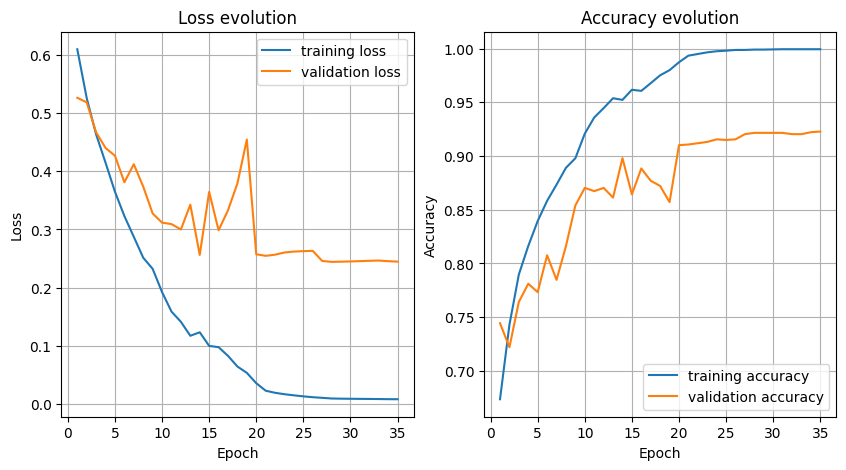

In [130]:
# Load simple model data
simple_model.compile(
    optimizer="adam", loss=keras.losses.binary_crossentropy, metrics=["accuracy"]
)

simple_model.load_weights("./models_data/simple_model/checkpoint.weights.h5")
hist_simple_model = json.load(open("./models_data/hist_simple_model.json", "r"))
# epoch_times_simple_model = pickle.load(open("models_data/epoch_time_simple.pkl", "rb"))


# Plot loss and accuracy
if type(hist_simple_model) == dict:
    loss_accuracy_plot_loaded_hist(hist_simple_model)
else:
    loss_accuracy_plot(hist_simple_model)

### VGG-like Model

In [132]:
vgg_model = Sequential()

vgg_model.add(Conv2D(32, (3, 3), input_shape=input_shape_all, activation="relu"))
vgg_model.add(MaxPooling2D())

vgg_model.add(Conv2D(64, (3, 3), activation="relu"))
vgg_model.add(MaxPooling2D())

vgg_model.add(Conv2D(128, (3, 3), activation="relu"))
vgg_model.add(MaxPooling2D())

vgg_model.add(Conv2D(128, (3, 3), strides=(2, 2), activation="relu"))
vgg_model.add(MaxPooling2D())

vgg_model.add(Flatten())
vgg_model.add(Dense(128, activation="relu"))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation="sigmoid"))

In [134]:
vgg_model.compile(
    optimizer="adam", loss=keras.losses.binary_crossentropy, metrics=["accuracy"]
)

vgg_model_time_callback = TimeHistory()
checkpoint_save = ModelCheckpoint(
    "./models_data/vgg_like_model/checkpoint.weights.h5",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)

t = datetime.datetime.now()
hist_vgg = vgg_model.fit(
    train_data_scaled,
    validation_data=test_data_scaled,
    callbacks=[
        vgg_model_time_callback,
        early_stopping,
        checkpoint_save,
        reduce_lr_loss,
    ],
    epochs=10,
)
t_vgg_model = datetime.datetime.now() - t
print("Training time: %s" % (datetime.datetime.now() - t))

# Save runtime and training history
pickle.dump(vgg_model_time_callback.times, open("./models_data/epoch_time_vgg.pkl", "wb"))

hist_dict = {}

for i, key in enumerate(hist_vgg.history.keys()):
    hist_dict[key] = np.array(list(hist_vgg.history.values())).astype(float)[i].tolist()

json.dump(hist_dict, open("./models_data/hist_vgg.json", "w"))

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.5991 - loss: 0.6847 - val_accuracy: 0.7298 - val_loss: 0.5564 - learning_rate: 0.0010
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7325 - loss: 0.5339 - val_accuracy: 0.7913 - val_loss: 0.4481 - learning_rate: 0.0010
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.7874 - loss: 0.4362 - val_accuracy: 0.8263 - val_loss: 0.3741 - learning_rate: 0.0010
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.8206 - loss: 0.3631 - val_accuracy: 0.8583 - val_loss: 0.3064 - learning_rate: 0.0010
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.8529 - loss: 0.2964 - val_accuracy: 0.8534 - val_loss: 0.2927 - learning_rate: 0.0010
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.8460 - loss: 0.2925 - val_accuracy: 0.8824 - val_loss: 0.2262 - learning_rate: 0.0010
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.8759 - loss: 0.

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


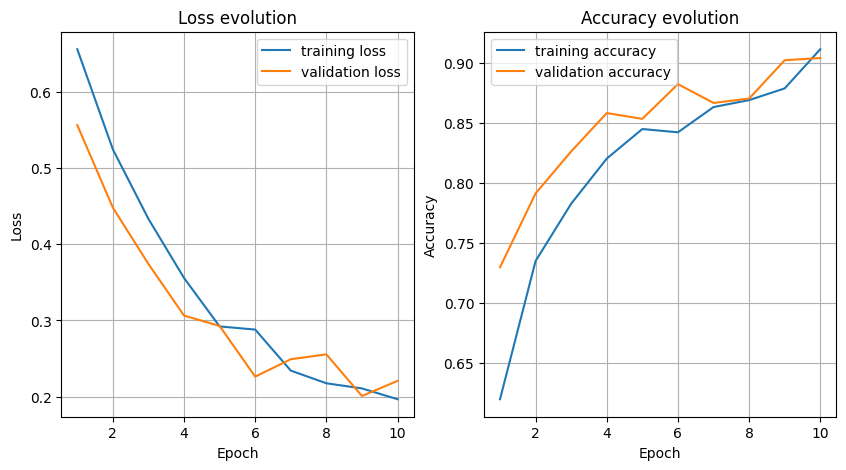

In [135]:
# Load simple model data
vgg_model.compile(
    optimizer="adam", loss=keras.losses.binary_crossentropy, metrics=["accuracy"]
)

vgg_model.load_weights("./models_data/vgg_like_model/checkpoint.weights.h5")
hist_vgg = json.load(open("./models_data/hist_vgg.json", "r"))
# epoch_times_vgg = pickle.load(open("./models_dataepoch_time_vgg.pkl", "rb"))


# Plot loss and accuracy
if type(hist_vgg) == dict:
    loss_accuracy_plot_loaded_hist(hist_vgg)
else:
    loss_accuracy_plot(hist_vgg)

### VGG16

In [167]:
from tensorflow.keras.layers import Input

vgg16_base_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
)

global_average_layer = keras.layers.GlobalAveragePooling2D()(vgg16_base_model.output)

dense_layer = Dense(64, activation="relu")(global_average_layer)

prediction_layer = Dense(1, activation="sigmoid")(dense_layer)

vgg16_model = keras.models.Model(
    inputs=vgg16_base_model.input, outputs=prediction_layer
)
vgg16_model.summary()

for layer in vgg16_base_model.layers:
    layer.trainable = False


optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
vgg16_model.compile(
    optimizer=optimiser, loss=keras.losses.binary_crossentropy, metrics=["accuracy"]
)

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,585 (56.26 MB)

 Trainable params: 14,747,585 (56.26 MB)

 Non-trainable params: 0 (0.00 B)

In [168]:
t = datetime.datetime.now()
vgg16_time_callback = TimeHistory()
hist_vgg16 = vgg16_model.fit(
    train_data_scaled, validation_data=test_data_scaled, callbacks=[vgg16_time_callback], epochs=10
)
print("Training time: %s" % (datetime.datetime.now() - t))

# Save the model and its training history
vgg16_model.save("models_data/vgg16_model.h5")
json.dump(hist_vgg16.history, open("models_data/hist_vgg16.json", "w"))
pickle.dump(vgg16_time_callback.times, open("models_data/epoch_time_vgg16.pkl", "wb"))

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4947s 27s/step - accuracy: 0.5026 - loss: 0.7327 - val_accuracy: 0.6019 - val_loss: 0.6417
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2957s 16s/step - accuracy: 0.6245 - loss: 0.6348 - val_accuracy: 0.6761 - val_loss: 0.6085
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2846s 16s/step - accuracy: 0.6799 - loss: 0.6061 - val_accuracy: 0.7250 - val_loss: 0.5803
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2276s 12s/step - accuracy: 0.7187 - loss: 0.5825 - val_accuracy: 0.7352 - val_loss: 0.5586
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2491s 14s/step - accuracy: 0.7204 - loss: 0.5638 - val_accuracy: 0.7334 - val_loss: 0.5413
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1995s 11s/step - accuracy: 0.7242 - loss: 0.5485 - val_accuracy: 0.7358 - val_loss: 0.5270
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2567s 14s/step - accuracy: 0.7246 - loss: 0.5353 - val_accuracy: 0.7364 - val_loss: 0.5144
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2905s 16s/step - accuracy: 0.7271 - loss: 0

Training time: 7:16:17.392870


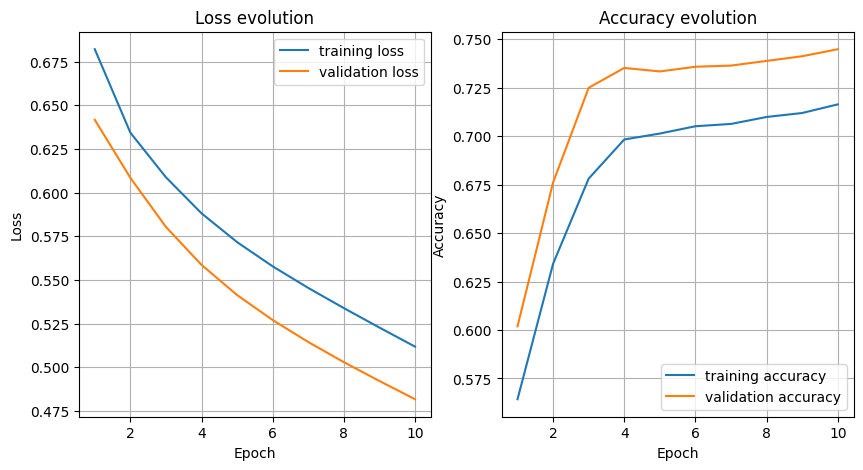

In [171]:
# Load data from VGG16 model
vgg16_model = tf.keras.models.load_model(os.getcwd() + "/models_data/vgg16_model.h5")
hist_vgg16 = json.load(open(os.getcwd() + "/models_data/hist_vgg16.json", "r"))
epoch_times_vgg16 = pickle.load(open(os.getcwd() + "/models_data/epoch_time_vgg16.pkl", "rb"))

# Plot loss and accuracy
if type(hist_vgg16) == dict:
    loss_accuracy_plot_loaded_hist(hist_vgg16)
else:
    loss_accuracy_plot(hist_vgg16)

### Model Comparison

In [173]:
# Get the labels of the original dataset. Using keras.
test_data_labels = np.array([])
for batch in test_data_scaled:
    (image, label) = batch
    test_data_labels = np.concatenate([test_data_labels, label])

# Predict the results for test data
simple_pred = simple_model.predict(test_data_scaled)
simple_pred_classes = (simple_pred > 0.5).astype(np.uint8)

vgg_pred = vgg_model.predict(test_data_scaled)
vgg_pred_classes = (vgg_pred > 0.5).astype(np.uint8)

vgg16_pred = vgg16_model.predict(test_data_scaled)
vgg16_pred_classes = (vgg16_pred > 0.5).astype(np.uint8)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 285s 5s/step


Accuracy on the validation set of the Simple model is 0.923
Accuracy on the validation set of the VGG-like model is 0.904
Accuracy on the validation set of the VGG16 model is 0.745


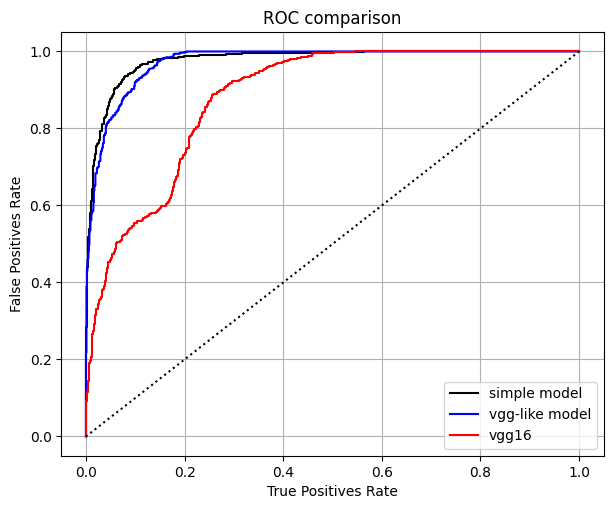

In [174]:
# Calculate true positive rate and false positive rate to generate
# ROC curve plots
tpr_simple, fpr_simple, thresh_simple = roc_curve(test_data_labels, simple_pred)
tpr_vgg, fpr_vgg, thresh_vgg = roc_curve(test_data_labels, vgg_pred)
tpr_vgg16, fpr_vgg16, thresh_vgg16 = roc_curve(test_data_labels, vgg16_pred)

fig, axes = plt.subplots(figsize=(7, 5.5))
axes.plot(tpr_simple, fpr_simple, "k-", label="simple model")
axes.plot(tpr_vgg, fpr_vgg, "b-", label="vgg-like model")
axes.plot(tpr_vgg16, fpr_vgg16, "r-", label="vgg16")
axes.plot([0, 1], [0, 1], "k:")

axes.grid()

axes.legend(loc="best")

axes.set_xlabel("True Positives Rate")
axes.set_ylabel("False Positives Rate")
axes.set_title("ROC comparison")

# Print accuracy on validation score in case the ROC curve comparison
# is confussing
print(
    "Accuracy on the validation set of the Simple model is %.3f"
    % accuracy_score(test_data_labels, simple_pred_classes)
)
print(
    "Accuracy on the validation set of the VGG-like model is %.3f"
    % accuracy_score(test_data_labels, vgg_pred_classes)
)
print(
    "Accuracy on the validation set of the VGG16 model is %.3f"
    % accuracy_score(test_data_labels, vgg16_pred_classes)
)

In [177]:
simple_model.save("models_data/simple_model.h5")